In [74]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
from scipy.sparse.linalg import spsolve, gmres
from scipy import sparse

In [75]:
%run geometry_mesh.ipynb #Mesh geometry

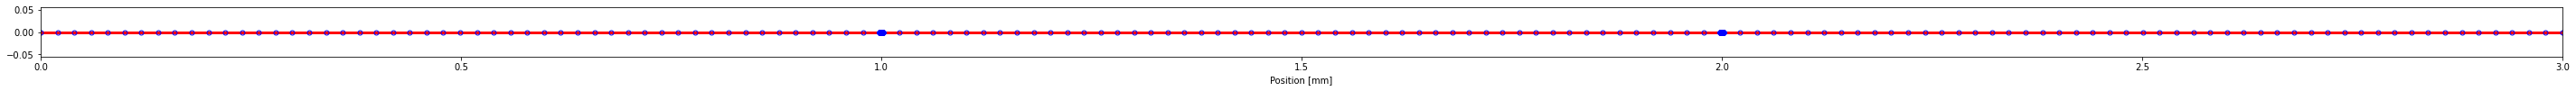

In [76]:
x_min = min(x_no) #find min x (for the mesh plot)
x_max = max(x_no) #find max x

fig = plt.figure(figsize=(50,1)) #Plot Mesh
ax = fig.add_subplot(111)
ax.set_xlim(10*x_min,10*x_max)
ax.set_xlabel("Position [mm]")

for i in range(Ne):
    ax.plot([10*x_no[i], 10*x_no[i+1]], [0,0], color="red", linewidth = 3)
    
for i in range(Nn):
    ax.plot(10*x_no[i], 0, marker="o", color = "blue", markersize = 5, fillstyle='none')

In [77]:
%run Model_parameters.ipynb #Parameters for 1d Transistor

x_no = x_no/r_norm #Normalize distance

In [78]:
#Setting up arrays for the quantities to calculate

n = np.empty(Nn) #electron concetration
p = np.empty(Nn) #hole concentration
Nd = np.empty(Nn) #donor ions concentration
Na = np.empty(Nn) #acceptor ions concentration
U = np.empty(Nn) #recombination rate
V = np.empty(Nn) #electric potential


Text(0.5, 0, 'distance [mm]')

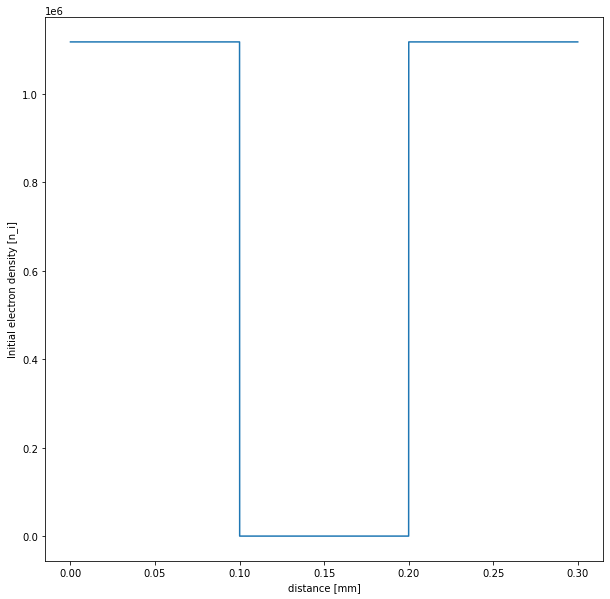

In [79]:
#Setting up initial values

node_count = 0
for i in range(N_e + int((N_j1/2))): #normalized
    Nd[node_count] = N_DE/n_norm 
    Na[node_count] = 0
    n[node_count] = (1/2*(N_DE + m.sqrt(N_DE**2 + 4*(n_norm**2))))/n_norm 
    p[node_count] = 1/n[node_count]
    node_count += 1
    
for i in range(N_b + int((N_j1/2)) + int((N_j2/2))): #normalized
    Nd[node_count] = 0
    Na[node_count] = N_AB/n_norm
    p[node_count] = (1/2*(N_AB + m.sqrt(N_AB**2 + 4*(n_norm**2))))/n_norm
    n[node_count] = 1/p[node_count]
    node_count += 1
    
for i in range(N_c + int((N_j2/2)) + 1): #normalized
    Nd[node_count] = N_DC/n_norm
    Na[node_count] = 0
    n[node_count] = (1/2*(N_DC + m.sqrt(N_DC**2 + 4*(n_norm**2))))/n_norm
    p[node_count] = 1/n[node_count]
    node_count += 1

#calculate recombination rate - normalized
for i in range(Nn):
    U[i] = (n[i]*p[i] - 1)/(tau_p*(n[i]+1) + tau_n*(p[i]+1))

    
#Visualize intial carrier densities
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(x_no*r_norm,n)
ax.set_ylabel("Initial electron density [n_i]")
ax.set_xlabel("distance [mm]")

Text(0, 0.5, 'Nodes')

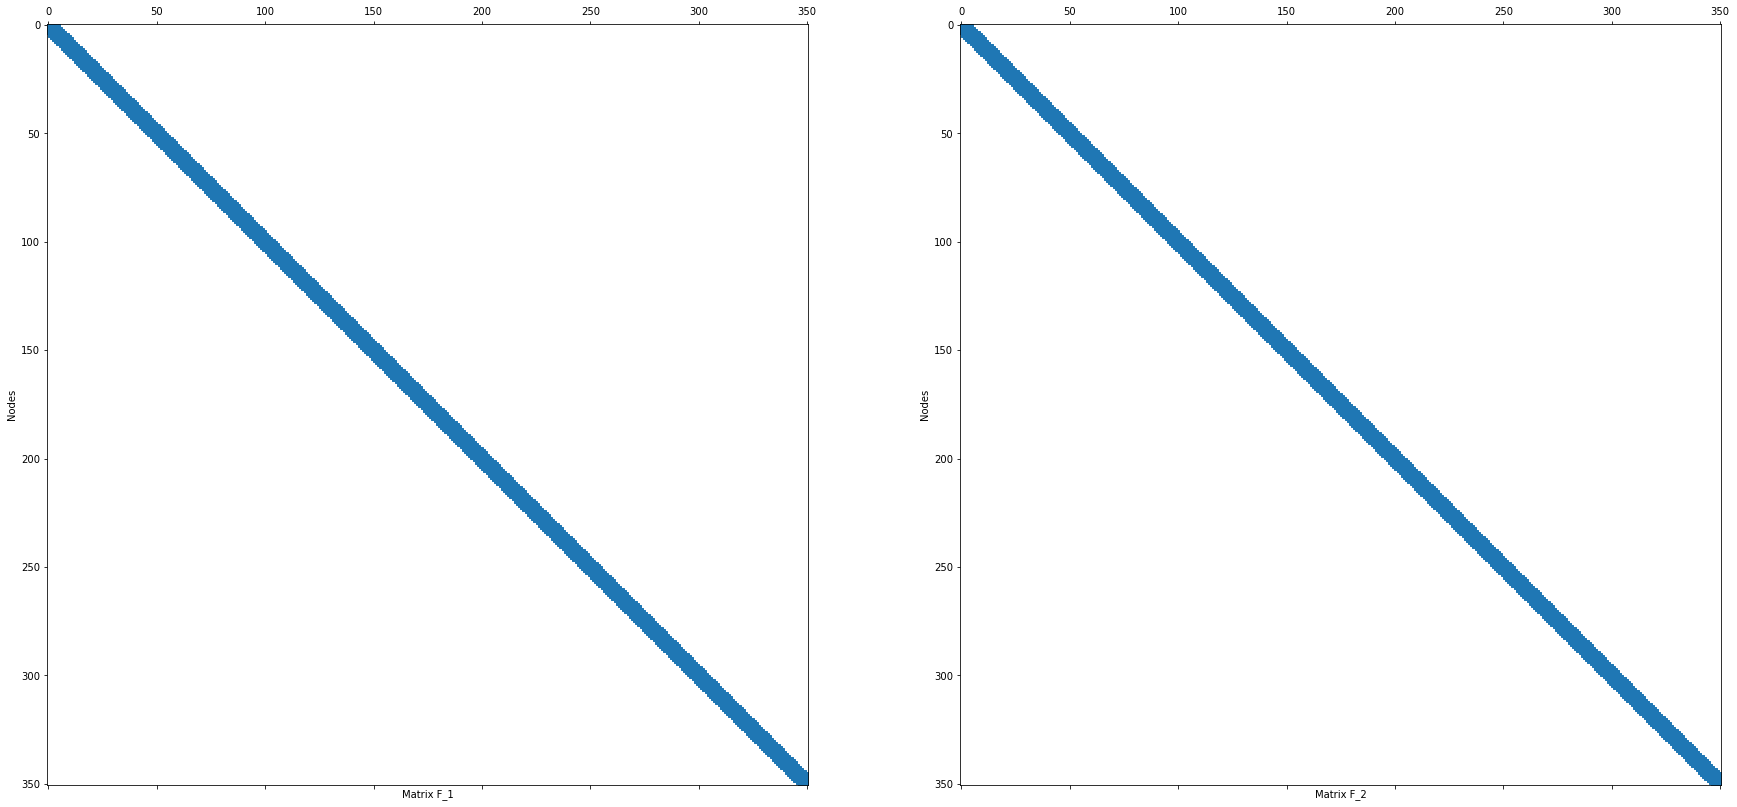

In [80]:
%run matrix_assembly_1d.ipynb #Matrix assembly for F^1 and F^2 - constant matrices that do not change in iterations

#Visualize sparse matrices F_1 and F_2
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.spy(F_1)
ax2.spy(F_2)
ax1.set_xlabel("Matrix F_1")
ax1.set_ylabel("Nodes")
ax2.set_xlabel("Matrix F_2")
ax2.set_ylabel("Nodes")

In [81]:
#Impose boundary conditions 

#AV = B -- Matrix equation solved below - imposing boundary conditions
A = sparse.lil_matrix.copy(F_1) #Copy F_1 
B = sparse.lil_matrix.dot(F_2,(p-n+Nd-Na)) #matrix multiplication of right side
A[0,0] = 0
A[0,1] = 0
A[0,0] = 1
A[M-1,M-2] = 0
A[M-1,M-1] = 0
A[M-1,M] = 0
A[M-1,M-1] = 1
A[Nn-1,Nn-2] = 0
A[Nn-1,Nn-1] = 0
A[Nn-1,Nn-1] = 1


B[0] = V_built_EB
B[M-1] = 0
B[Nn-1] = V_built_CB

In [82]:
class gmres_counter(object): #class for the residual capture used in residual visualization graphs
    def __init__(self):
        self.relres = []
        self.niter = 0
    def __call__(self, rk=None):
        self.relres.append(rk)
        self.niter += 1

In [83]:
#Solve for initial potential V
counterV = gmres_counter()

V, info = gmres(A,B,tol=1e-8,callback=counterV) #SOLVE

#Calculating matrix G^1 for a given potential distribution-------------------------------------------------------------------------------
G_1 = sparse.lil_matrix((Nn,Nn))

%run G_matrix_assembly.ipynb


#impose boundary condition for n_new and p_new calculations-------------------------------------------------------------------------------

C = G_1.multiply(1/gamma_n) - F_1.multiply(1/gamma_n)
D = -sparse.lil_matrix.dot(F_2,U)
C[0,0] = 0
C[0,1] = 0
C[0,0] = 1
C[Nn-1,Nn-2] = 0
C[Nn-1,Nn-1] = 0
C[Nn-1,Nn-1] = 1

D[0] = (1/2*(N_DE + m.sqrt(N_DE**2 + 4*(n_norm**2))))/n_norm
D[Nn-1] = (1/2*(N_DC + m.sqrt(N_DC**2 + 4*(n_norm**2))))/n_norm


E = -G_1.multiply(1/gamma_p) - F_1.multiply(1/gamma_p)
F = -sparse.lil_matrix.dot(F_2,U)

E[0,0] = 0
E[0,1] = 0
E[0,0] = 1
E[Nn-1,Nn-2] = 0
E[Nn-1,Nn-1] = 0
E[Nn-1,Nn-1] = 1

F[0] = 1/((1/2*(N_DE + m.sqrt(N_DE**2 + 4*(n_norm**2))))/n_norm)
F[Nn-1] = 1/((1/2*(N_DC + m.sqrt(N_DC**2 + 4*(n_norm**2))))/n_norm)

# Solve equations for n and p --- C{n_new} = D --- E{p_new} = F-------------------------------------------------------------------------------

n_new = np.empty(Nn)
p_new = np.empty(Nn)

countern = gmres_counter()
counterp = gmres_counter()

n_new, info = gmres(C,D,tol=1e-8,callback=countern)
p_new, info = gmres(E,F,tol=1e-8,callback=counterp)

# compute new p and n for given alfa (under-relaxation method)-------------------------------------------------------------------------------

alfa = 0.01 #relaxation factor

p = (1-alfa)*p + alfa*p_new
n = (1-alfa)*n + alfa*n_new

In [84]:
#RESIDUAL FOR POTENTIAL SOLUTION

# relres = np.asarray(counterV.relres)
# iterations = np.arange(1, relres.size+1,1)
# figR = plt.figure(figsize=(10,10))
# axR = figR.add_subplot(1,1,1)
# axR.plot(iterations,relres)
# axR.set_yscale('log')
# axR.set_xlabel('Iteration Number')
# axR.set_ylabel('Relative Residual')

Text(0.5, 0, 'distance [mm]')

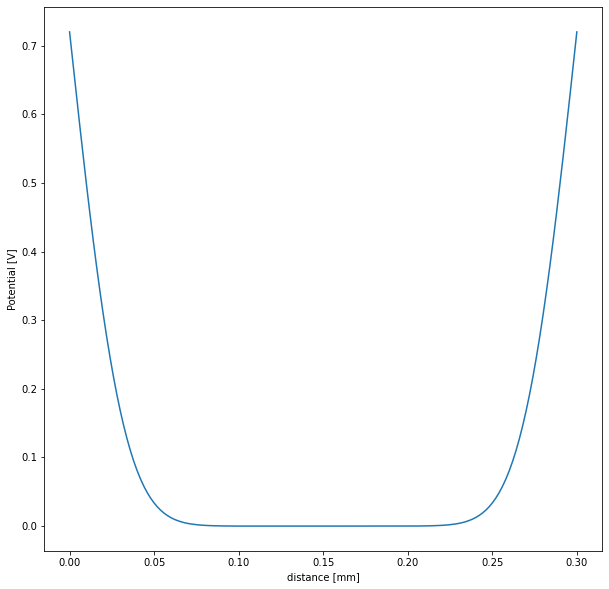

In [85]:
#INITIAL POTENTIAL DISTRIBUTION

lin = np.linspace(0,Ne, Ne+1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(x_no*r_norm,V*V_norm)
ax.set_ylabel("Potential [V]")
ax.set_xlabel("distance [mm]")

Text(0, 0.5, 'Nodes')

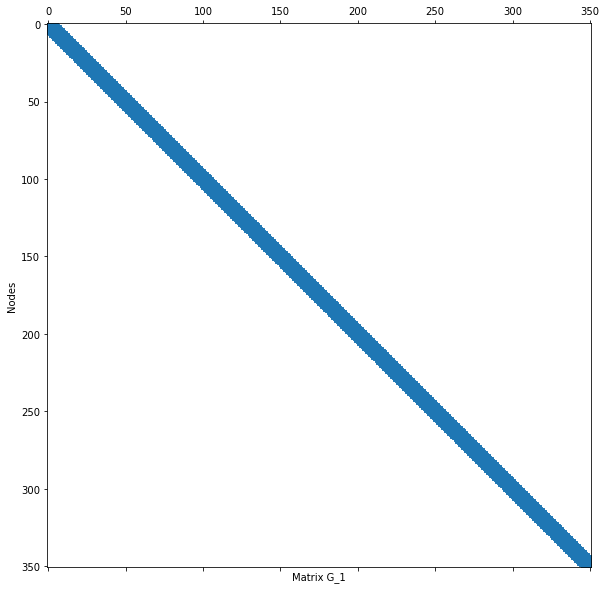

In [86]:
#G_1 sparse matrix visualization
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.spy(G_1)
ax1.set_xlabel("Matrix G_1")
ax1.set_ylabel("Nodes")

In [87]:
#RESIDUAL FOR p_new OR n_new SOLUTION

# relres = np.asarray(countern.relres)
# iterations = np.arange(1, relres.size+1,1)
# figR = plt.figure(figsize=(10,10))
# axR = figR.add_subplot(1,1,1)
# axR.plot(iterations,relres)
# axR.set_yscale('log')
# axR.set_xlabel('Iteration Number')
# axR.set_ylabel('Relative Residual')

Text(0.5, 0, 'distance [mm]')

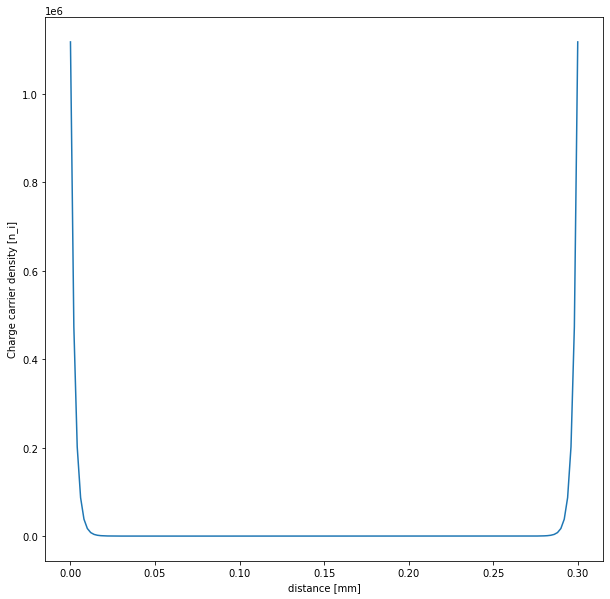

In [88]:
#p_new or n_new carrier density

lin = np.linspace(0,Ne, Ne+1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(x_no*r_norm,n_new)
ax.set_ylabel("Charge carrier density [n_i]")
ax.set_xlabel("distance [mm]")
    

Text(0.5, 0, 'distance [mm]')

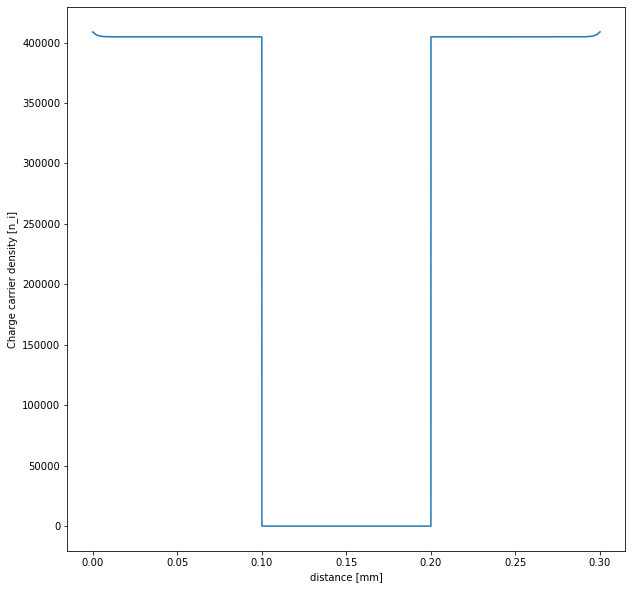

In [95]:
#CARRIER DENSITY AFTER FIRST UNDER RELAXATION ITERATION

lin = np.linspace(0,Ne, Ne+1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(x_no*r_norm,n)
ax.set_ylabel("Charge carrier density [n_i]")
ax.set_xlabel("distance [mm]")

In [90]:
#NOW ASSEMBLE ITERATION LOOP (DUPLICATE CODE)

iterations = 100
difference = np.empty((iterations,4)) #track the differences between new p and old_p after iteration
for ind in range(iterations): #In the end this should have the condition for stopping the iteration and finishing the calculations
    #AV = B -- Matrix equation solved below - imposing boundary conditions
    A = sparse.lil_matrix.copy(F_1)
    B = sparse.lil_matrix.dot(F_2,(p-n+Nd-Na))
    A[0,0] = 0
    A[0,1] = 0
    A[0,0] = 1
    A[M-1,M-2] = 0
    A[M-1,M-1] = 0
    A[M-1,M] = 0
    A[M-1,M-1] = 1
    A[Nn-1,Nn-2] = 0
    A[Nn-1,Nn-1] = 0
    A[Nn-1,Nn-1] = 1


    B[0] = V_built_EB
    B[M-1] = 0
    B[Nn-1] = V_built_CB
    #---------------------------------------------------------------
    
    #Solve for initial potential V
    V, info = gmres(A,B,tol=1e-8,callback=counterV)

    #Calculating matrix G^1 for a given potential distribution
    G_1[:,:] = 0
    %run G_matrix_assembly.ipynb
    
    #computing new recombination rate
    for j in range(Nn):
        U[j] = (n[j]*p[j] - 1)/(tau_p*(n[j]+1) + tau_n*(p[j]+1))
        
    #impose boundary condition for n_new and p_new calculations

    C = G_1.multiply(1/gamma_n) - F_1.multiply(1/gamma_n)
    D = -sparse.lil_matrix.dot(F_2,U)

    C[0,0] = 0
    C[0,1] = 0
    C[0,0] = 1
    C[Nn-1,Nn-2] = 0
    C[Nn-1,Nn-1] = 0
    C[Nn-1,Nn-1] = 1

    D[0] = (1/2*(N_DE + m.sqrt(N_DE**2 + 4*(n_norm**2))))/n_norm
    D[Nn-1] = (1/2*(N_DC + m.sqrt(N_DC**2 + 4*(n_norm**2))))/n_norm


    E = -G_1.multiply(1/gamma_p) - F_1.multiply(1/gamma_p)
    F = -sparse.lil_matrix.dot(F_2,U)

    E[0,0] = 0
    E[0,1] = 0
    E[0,0] = 1
    E[Nn-1,Nn-2] = 0
    E[Nn-1,Nn-1] = 0
    E[Nn-1,Nn-1] = 1

    F[0] = 1/((1/2*(N_DE + m.sqrt(N_DE**2 + 4*(n_norm**2))))/n_norm)
    F[Nn-1] = 1/((1/2*(N_DC + m.sqrt(N_DC**2 + 4*(n_norm**2))))/n_norm)
    
    # Solve equations for n and p --- C{n_new} = D   --- E{p_new} = F
    
    n_new, info = gmres(C,D,tol=1e-8,callback=countern)
    p_new, info = gmres(E,F,tol=1e-8,callback=counterp)
    
    # compute new p and n for given alfa

    alfa = 0.01 #relaxation factor
    
    old_p = np.copy(p)
    old_n = np.copy(n)
    
    p = (1-alfa)*p + alfa*p_new
    n = (1-alfa)*n + alfa*n_new
    
    difference[ind] = [max(p-old_p),min(p-old_p), max(n-old_n),min(n-old_n)]
    #ITERATION LOOP FINISHED - OBTAINED p AND n - RETURN TO BEGINNING OF ITERATION
    

Text(0.5, 0, 'distance [mm]')

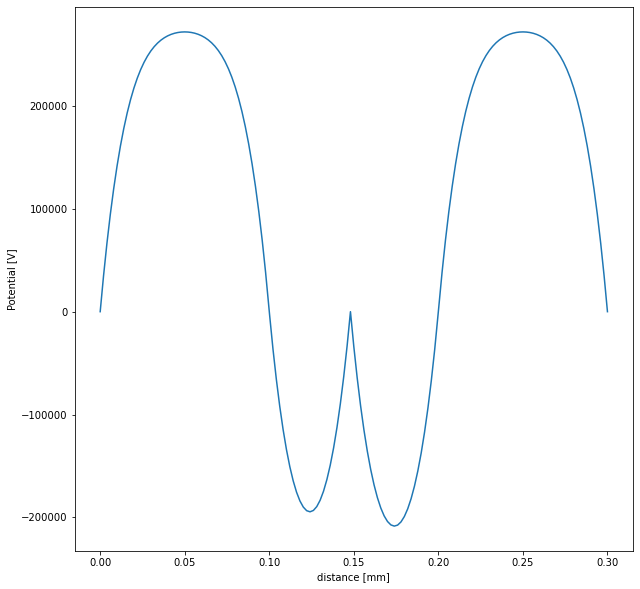

In [91]:
#POTENTIAL DISTRIBUTION

lin = np.linspace(0,Ne, Ne+1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(x_no*r_norm,V*V_norm)
ax.set_ylabel("Potential [V]")
ax.set_xlabel("distance [mm]")

Text(0.5, 0, 'distance [mm]')

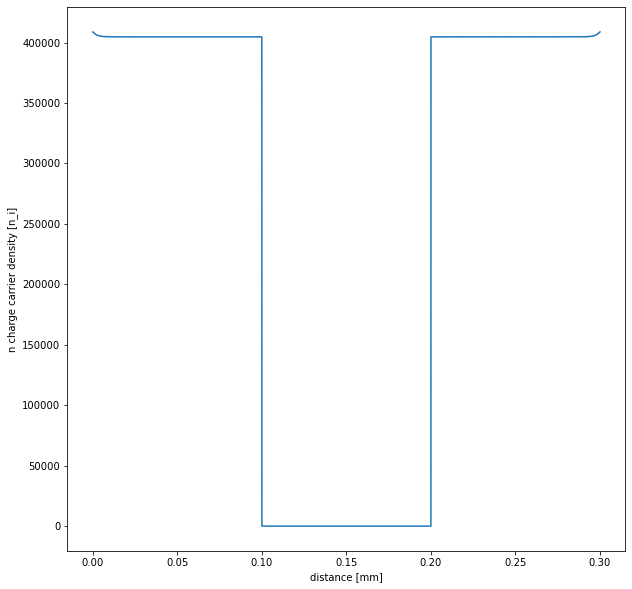

In [92]:
#Charge densities after iteration loop

lin = np.linspace(0,Ne, Ne+1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(x_no*r_norm,n)
ax.set_ylabel("n charge carrier density [n_i]")
ax.set_xlabel("distance [mm]")

Text(0.5, 0, 'distance [mm]')

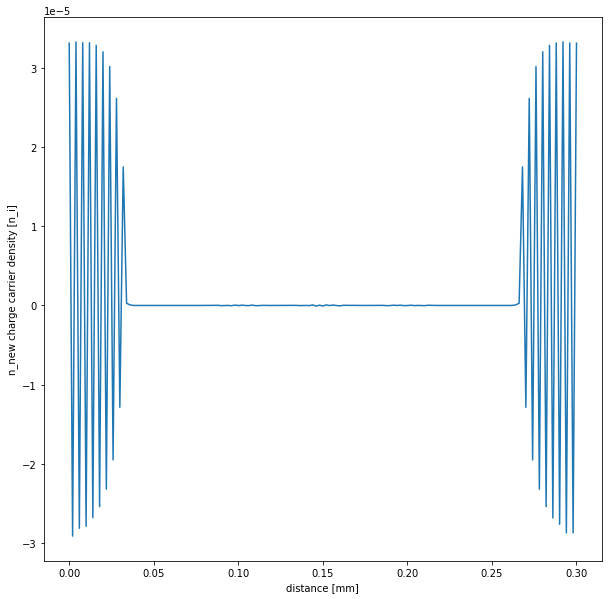

In [93]:
#p_new or n_new carrier density at the end

lin = np.linspace(0,Ne, Ne+1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(x_no*r_norm,n_new)
ax.set_ylabel("n_new charge carrier density [n_i]")
ax.set_xlabel("distance [mm]")